<a href="https://colab.research.google.com/github/granja17/Redes-Neurais-CNN-MLP/blob/main/Projeto_ACA_Gabriel_Ingrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurações Iniciais e Importações

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
from skimage.io import imread, imshow
import re
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch.nn as nn
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import torch.optim as optim


# Pré-processamento


In [ ]:
#Armazena o caminho para o diretório onde estão localizados os dados de treinamento.
train_dataset_path = '/content/drive/MyDrive/ACA - Aprendizagem Computacional Avancada/4-Project-Support/data-students/TRAIN'

#Configuração de Parâmetros
IMG_WIDTH = 75
IMG_HEIGHT = 75
BATCH_SIZE = 32

In [ ]:
#Transformação das Imagens
transform = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4167, 0.4085, 0.3859], std=[0.2310, 0.2279, 0.2452])
])

#Carregamento do Dataset
train_datagen = datasets.ImageFolder(root=train_dataset_path, transform=transform)


In [ ]:
#Divisão dos Dados
labels = [label for _, label in train_datagen.samples]

train_idx, test_idx = train_test_split(
    range(len(labels)),
    test_size=0.2,  # 20% dos dados para teste
    stratify=labels,
    random_state=12
)

#Cria subconjuntos de dados usando os índices
train_dataset = Subset(train_datagen, train_idx)
test_dataset = Subset(train_datagen, test_idx)

#DataLoaders para os conjuntos de treino e teste
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

#Análise das Imagens
imgs = torch.stack([img_t for img_t, _ in train_datagen], dim=3)
imgs.view(3, -1).mean(dim=1)
imgs.view(3, -1).std(dim=1)


tensor([1.0002, 1.0001, 1.0000])

In [ ]:
#Criação de um Dicionário de Rótulos Baseado nos Índices das Classes
labels = {value: key for key, value in train_datagen.class_to_idx.items()}
print(labels)

#Carregamento e Mapeamento de Rótulos Reais de um Arquivo CSV
the_real_labels = {}
with open("/content/drive/MyDrive/ACA - Aprendizagem Computacional Avancada/4-Project-Support/data-students/labels.csv","r") as label_f:
    for line in label_f.readlines()[1:]:
        label_value, label_description = line.strip().split(";")
        the_real_labels[int(label_value)] = label_description
print(the_real_labels)
print("Mapeamentos de rótulos para classes presentes nos conjuntos de dados de treinamento e teste\n")
for key, value in labels.items():
    print(f"{key} : {value} - {the_real_labels[int(value)]}")
the_labels_map = {key: value for key, value in train_datagen.class_to_idx.items()}
print(len(labels))

{0: '12', 1: '13', 2: '24', 3: '37', 4: '38', 5: '39', 6: '44', 7: '50', 8: '6'}
{6: 'Speed limit (70km/h)', 12: 'Dont Go Left or Right', 13: 'Dont Go Right', 24: 'Go Right', 37: 'Children crossing', 38: 'Dangerous curve to the right', 39: 'Dangerous curve to the left', 44: 'Go left or straight', 50: 'Fences'}
Mapeamentos de rótulos para classes presentes nos conjuntos de dados de treinamento e teste

0 : 12 - Dont Go Left or Right
1 : 13 - Dont Go Right
2 : 24 - Go Right
3 : 37 - Children crossing
4 : 38 - Dangerous curve to the right
5 : 39 - Dangerous curve to the left
6 : 44 - Go left or straight
7 : 50 - Fences
8 : 6 - Speed limit (70km/h)
9


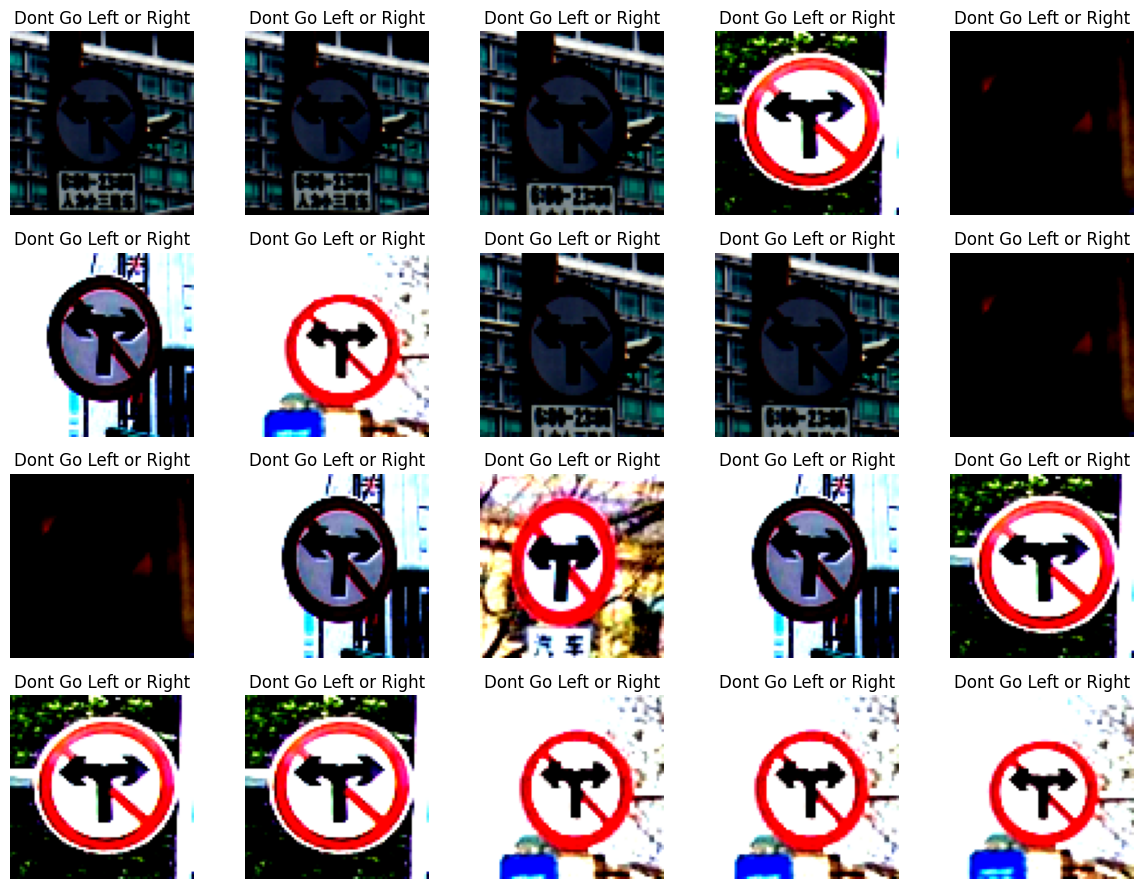

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(12, 9))
dataiter = iter(train_datagen)
idx = 0

for i in range(4):
    for j in range(5):
        images, l = next(dataiter)
        img = images
        label = the_real_labels[int(labels[l])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(img.permute(1,2,0))
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.show()

# Perceptron Multi-Camadas (MLP)

Definição do Modelo

In [ ]:
#Definição do Modelo
class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()

        self.layers = nn.Sequential(
            nn.Linear(3 * 75 * 75, 150),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(150, 60),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(60, 30),
            nn.ReLU(),
            nn.Linear(30, 9),
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.layers(x)

#Configuração do Dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Rodando na {device}")

model = MLPClassifier().to(device)

Rodando na cpu


Definição da Função de Perda e do Otimizador

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Treinamento e Validação

In [ ]:
def train(model, Dataloader, loss_func, optimizer):
  model.train()
  cumloss = 0.0

  for imgs, labels in Dataloader:
    imgs, labels = imgs.to(device), labels.to(device)

    optimizer.zero_grad()

    pred = model(imgs)

    loss = loss_func(pred, labels)
    loss.backward()
    optimizer.step()

    cumloss += loss.item()

  return cumloss / len(Dataloader)

def validate(model, Dataloader, loss_func):
  model.eval()
  cumloss = 0.0

  with torch.no_grad():
    for imgs, labels in Dataloader:
      imgs, labels = imgs.to(device), labels.to(device)

      pred = model(imgs)
      loss = loss_func(pred, labels)
      cumloss += loss.item()

  return cumloss / len(Dataloader)

Processo de Treinamento


In [ ]:
epochs = 150
train_losses = []
test_losses = []
for t in range(epochs):
  train_loss = train(model, train_loader, loss_func, optimizer)
  train_losses.append(train_loss)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")

  test_loss = validate(model, test_loader, loss_func)
  test_losses.append(test_loss)

Epoch: 0; Train Loss: 1.9241232505211463
Epoch: 10; Train Loss: 0.23726564588455054
Epoch: 20; Train Loss: 0.23380163942392057
Epoch: 30; Train Loss: 0.1193857271797382
Epoch: 40; Train Loss: 0.046139539362719424
Epoch: 50; Train Loss: 0.07005387933363985
Epoch: 60; Train Loss: 0.045784413874991096
Epoch: 70; Train Loss: 0.04198654672095122
Epoch: 80; Train Loss: 0.023510092209142804
Epoch: 90; Train Loss: 0.09086448252827932
Epoch: 100; Train Loss: 0.10646528421560876
Epoch: 110; Train Loss: 0.055683929291332715
Epoch: 120; Train Loss: 0.02401779600320599
Epoch: 130; Train Loss: 0.01187184889221927
Epoch: 140; Train Loss: 0.02087864349022521


# Avaliações MLP

Monitoramento das Funções de Perda Durante Treinamento e Teste

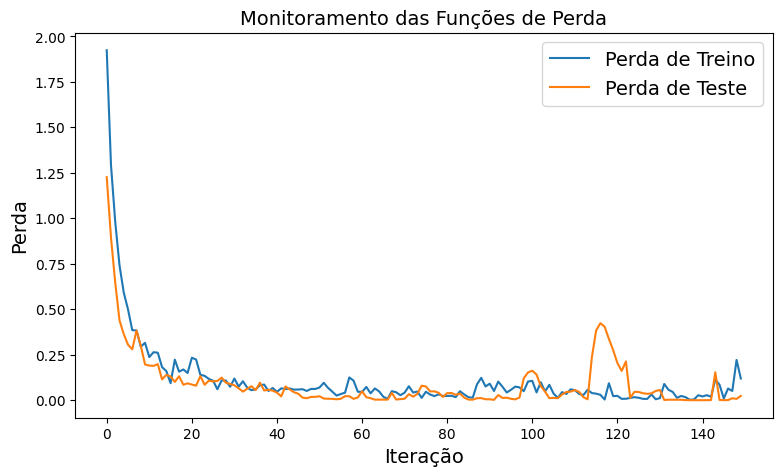

In [ ]:
#Plotagem de Perdas
def plot_losses(losses):
    fig = plt.figure(figsize=(9, 5))
    ax = fig.gca()
    for loss_name, loss_values in losses.items():
        ax.plot(loss_values, label=loss_name)
    ax.legend(fontsize="14")
    ax.set_xlabel("Iteração", fontsize="14")
    ax.set_ylabel("Perda", fontsize="14")
    ax.set_title("Monitoramento das Funções de Perda", fontsize="14")

losses = {"Perda de Treino": train_losses, "Perda de Teste": test_losses}
plot_losses(losses)

Heatmap da Matriz de Confusão


In [ ]:
def make_confusion_matrix(model, loader, n_classes):
    confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int64)
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t, p] += 1
    return confusion_matrix

def evaluate_accuracy(model, dataloader, the_real_labels, verbose=True):
    classes = [the_real_labels[i] for i in sorted(the_real_labels)]# Obter os nomes das classes a partir do mapeamento de rótulos
    n_classes = len(classes)

    # Calculando a matriz de confusão
    confusion_matrix = make_confusion_matrix(model, dataloader, n_classes)

    if verbose:
        total_correct = 0.0
        total_prediction = 0.0
        for i, classname in enumerate(classes):
            correct_count = confusion_matrix[i][i].item()
            class_pred = torch.sum(confusion_matrix[i]).item()

            total_correct += correct_count
            total_prediction += class_pred

            if class_pred > 0:  # Evitar divisão por zero
                accuracy = 100 * float(correct_count) / class_pred
                print(f"Accuracy for class {classname:5s} is: {accuracy:.1f} %")
            else:
                print(f"No predictions for class {classname:5s}")

        global_accuracy = 100 * total_correct / total_prediction if total_prediction > 0 else 0
        print(f"Global accuracy is {global_accuracy:.1f}")

    return confusion_matrix

Accuracy for class Speed limit (70km/h) is: 100.0 %
Accuracy for class Dont Go Left or Right is: 100.0 %
Accuracy for class Dont Go Right is: 100.0 %
Accuracy for class Go Right is: 100.0 %
Accuracy for class Children crossing is: 100.0 %
Accuracy for class Dangerous curve to the right is: 100.0 %
Accuracy for class Dangerous curve to the left is: 83.3 %
Accuracy for class Go left or straight is: 100.0 %
Accuracy for class Fences is: 100.0 %
Global accuracy is 99.0


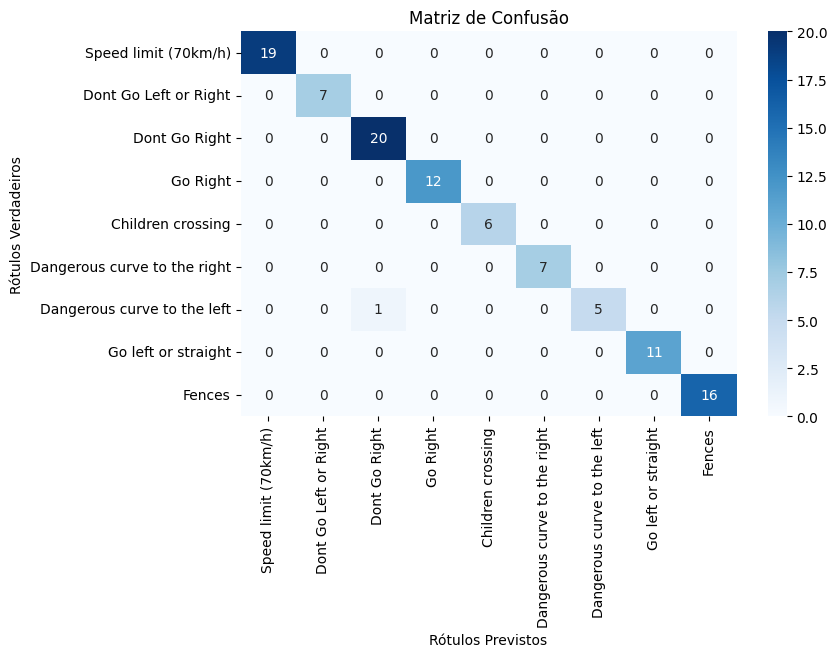

In [ ]:
confusion_matrix = evaluate_accuracy(model, test_loader, the_real_labels)

# Plotar a matriz de confusão como um heatmap
def plot_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(8,5))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusão')
    plt.ylabel('Rótulos Verdadeiros')
    plt.xlabel('Rótulos Previstos')
    plt.show()
class_names = [the_real_labels[i] for i in sorted(the_real_labels.keys())]
plot_confusion_matrix(confusion_matrix, class_names)

Precisão, Recall e F1-Score


In [ ]:
def precision_recall_fscore(confusion_matrix, class_names):
    precision = torch.diag(confusion_matrix) / torch.sum(confusion_matrix, axis=0)
    recall = torch.diag(confusion_matrix) / torch.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)

    precision = torch.nan_to_num(precision, nan=1.0)
    recall = torch.nan_to_num(recall, nan=1.0)
    f1_score = torch.nan_to_num(f1_score, nan=1.0)

    # Exibindo os resultados por classe
    for i, class_name in enumerate(class_names):
        print(f"Rótulos: {class_name}, Precision: {precision[i]:.2f}, Recall: {recall[i]:.2f}, F1-Score: {f1_score[i]:.2f}")

precision_recall_fscore(confusion_matrix, class_names)

Rótulos: Speed limit (70km/h), Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Rótulos: Dont Go Left or Right, Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Rótulos: Dont Go Right, Precision: 0.95, Recall: 1.00, F1-Score: 0.98
Rótulos: Go Right, Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Rótulos: Children crossing, Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Rótulos: Dangerous curve to the right, Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Rótulos: Dangerous curve to the left, Precision: 1.00, Recall: 0.83, F1-Score: 0.91
Rótulos: Go left or straight, Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Rótulos: Fences, Precision: 1.00, Recall: 1.00, F1-Score: 1.00


#Redes Neurais Convolucionais (CNNs)

Definição do Modelo

In [ ]:
class ConvolutionalModel(nn.Module):
    def __init__(self, num_classes=9, img_width=75, img_height=75):
        super().__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=6, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=6, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=6, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        def _get_conv_output(self, shape):
            o = self.convlayers(torch.rand(*(shape)))
            return int(np.prod(o.size()))

        output_size = _get_conv_output(self, (1, 3, img_width, img_height))
        self.flatten = nn.Flatten()
        # Camada de dropout adicionada
        self.dropout = nn.Dropout(0.5)
        self.linearlayers = nn.Sequential(
            nn.Linear(output_size, 512),  # Ajuste baseado na saída das camadas convolucionais
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout adicionado antes das camadas totalmente conectadas
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.convlayers(x)
        x = self.flatten(x)
        x = self.dropout(x)  # Aplicar dropout após achatamento
        return self.linearlayers(x)

In [ ]:
convmodel = ConvolutionalModel().to(device)

Definição do Otimizador e da Função de Perda

In [ ]:
loss_func2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.Adam(convmodel.parameters(), lr=0.001)


Treinamento e Validação


In [ ]:
def train(model, dataloader, loss_func, optimizer):
  model.train()
  cumloss = 0.0

  for imgs, labels in dataloader:
    imgs, labels = imgs.to(device), labels.to(device)

    optimizer.zero_grad()

    pred = model(imgs)

    loss = loss_func(pred, labels)
    loss.backward()
    optimizer.step()

    cumloss += loss.item()

  return cumloss / len(dataloader)

def validate(model, dataloader, loss_func):
  model.eval()
  cumloss = 0.0

  with torch.no_grad():
    for imgs, labels in dataloader:
      imgs, labels = imgs.to(device), labels.to(device)

      pred = model(imgs)
      loss = loss_func(pred, labels)
      cumloss += loss.item()

  return cumloss / len(dataloader)

Loop de Treinamento

In [ ]:
epochs = 150
conv_train_losses = []
conv_test_losses = []
for t in range(epochs):
  train_loss = train(convmodel, train_loader, loss_func2, optimizer2)
  conv_train_losses.append(train_loss)
  if t % 10 == 0:
    print(f"Epoch: {t}; Train Loss: {train_loss}")
  test_loss = validate(convmodel, test_loader, loss_func2)
  conv_test_losses.append(test_loss)

Epoch: 0; Train Loss: 1.59056595655588
Epoch: 10; Train Loss: 0.02197926246131269
Epoch: 20; Train Loss: 0.002591134254963925
Epoch: 30; Train Loss: 0.02731384218294317
Epoch: 40; Train Loss: 0.0003704125199594553
Epoch: 50; Train Loss: 0.00018213107075728028
Epoch: 60; Train Loss: 3.7267097389723436e-05
Epoch: 70; Train Loss: 0.0003615776568040019
Epoch: 80; Train Loss: 0.00018517832253250023
Epoch: 90; Train Loss: 6.54399926728589e-05
Epoch: 100; Train Loss: 2.6937811841120354e-05
Epoch: 110; Train Loss: 8.939243446967829e-05
Epoch: 120; Train Loss: 4.496661330659453e-05
Epoch: 130; Train Loss: 2.767540764545209e-05
Epoch: 140; Train Loss: 5.183137948104279e-06


#Avaliações CNNs

Monitoramento das Funções de Perda Durante Treinamento e Teste

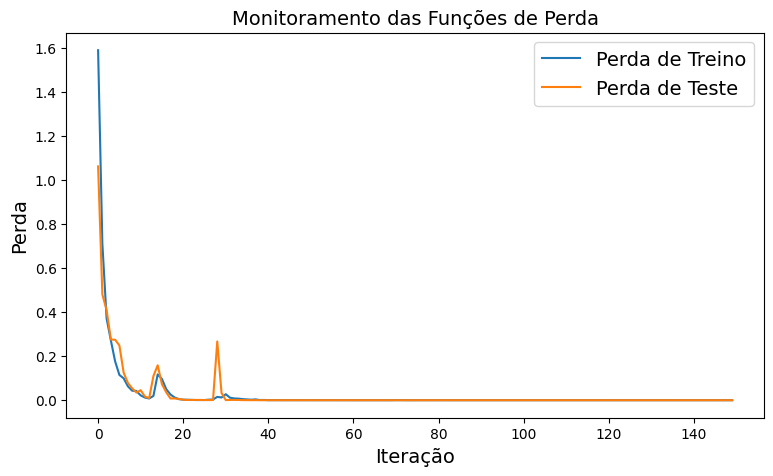

In [ ]:

conv_losses = {"Perda de Treino": conv_train_losses, "Perda de Teste": conv_test_losses}
plot_losses(conv_losses)

Heatmap da Matriz de Confusão

Accuracy for class Speed limit (70km/h) is: 100.0 %
Accuracy for class Dont Go Left or Right is: 100.0 %
Accuracy for class Dont Go Right is: 100.0 %
Accuracy for class Go Right is: 100.0 %
Accuracy for class Children crossing is: 100.0 %
Accuracy for class Dangerous curve to the right is: 100.0 %
Accuracy for class Dangerous curve to the left is: 100.0 %
Accuracy for class Go left or straight is: 100.0 %
Accuracy for class Fences is: 100.0 %
Global accuracy is 100.0


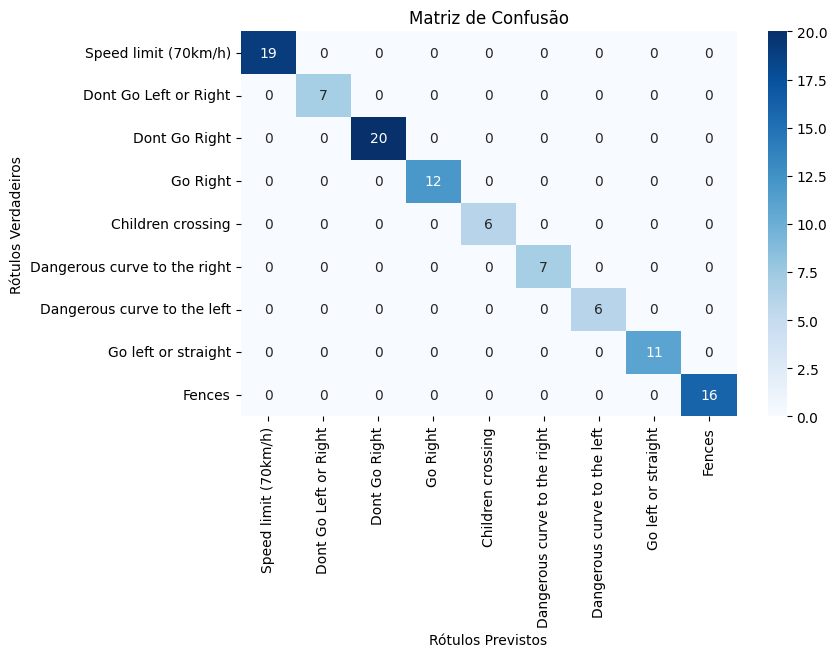

In [ ]:
# Calculando a matriz de confusão e plotando-a
class_names = [the_real_labels[i] for i in sorted(the_real_labels.keys())]
confusion_matrix_cnn = evaluate_accuracy(convmodel, test_loader, the_real_labels, device)
plot_confusion_matrix(confusion_matrix_cnn.numpy(), class_names)


Precisão, Recall e F1-Score

In [ ]:
precision_recall_fscore(confusion_matrix_cnn, class_names)

Rótulos: Speed limit (70km/h), Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Rótulos: Dont Go Left or Right, Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Rótulos: Dont Go Right, Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Rótulos: Go Right, Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Rótulos: Children crossing, Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Rótulos: Dangerous curve to the right, Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Rótulos: Dangerous curve to the left, Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Rótulos: Go left or straight, Precision: 1.00, Recall: 1.00, F1-Score: 1.00
Rótulos: Fences, Precision: 1.00, Recall: 1.00, F1-Score: 1.00


# Carregamento dos dados de teste e exportações

In [ ]:
import os
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

the_real_labels = {
    0: 12,
    1: 13,
    2: 24,
    3: 37,
    4: 38,
    5: 39,
    6: 44,
    7: 50,
    8: 6
}

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [img for img in os.listdir(root_dir) if img.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.images[idx]

IMG_WIDTH, IMG_HEIGHT = 75, 75
test_transform = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4167, 0.4085, 0.3859], std=[0.2310, 0.2279, 0.2452])
])

test_dataset = CustomImageDataset(
    root_dir='/content/drive/MyDrive/ACA - Aprendizagem Computacional Avancada/4-Project-Support/data-students/TEST',
    transform=test_transform
)

BATCH_SIZE = 32
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

def get_predictions(model, dataloader):
    model.eval()
    predictions = []
    filenames = []
    with torch.no_grad():
        for imgs, files in dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            filenames.extend(files)
    return predictions, filenames

def process_filenames(filenames):
    return [int(os.path.splitext(file)[0]) for file in filenames]

mlp_predictions, mlp_filenames = get_predictions(model, test_loader)
cnn_predictions, cnn_filenames = get_predictions(convmodel, test_loader)

processed_filenames = process_filenames(mlp_filenames)  # assume mlp_filenames and cnn_filenames are identical

mlp_submission_df = pd.DataFrame({
    'ID': processed_filenames,
    'Class': [the_real_labels[pred] for pred in mlp_predictions]
})

cnn_submission_df = pd.DataFrame({
    'ID': processed_filenames,
    'Class': [the_real_labels[pred] for pred in cnn_predictions]
})

mlp_submission_df = mlp_submission_df.sort_values('ID').reset_index(drop=True)
cnn_submission_df = cnn_submission_df.sort_values('ID').reset_index(drop=True)

mlp_submission_df.to_csv('/content/drive/MyDrive/mlp_submission2.csv', index=False)
cnn_submission_df.to_csv('/content/drive/MyDrive/cnn_submission2.csv', index=False)
